<a href="https://colab.research.google.com/github/akshaypat444/tensorflow_practice/blob/main/06_transfer_learning_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision Mini

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-04 04:11:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-03-04 04:11:32 (9.93 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Import modules and packages

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [3]:
def compare_historys(original_history, new_history, initial_epochs=5):

  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc, label="Training accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([5-1, 5-1], plt.ylim(), label="Start fine tunning")
  plt.legend(loc="lower right")
  plt.title("Training and validation accuracy")

  plt.figure(figsize=(8,8))
  plt.subplot(2,1,2)
  plt.plot(total_loss, label="Training loss")
  plt.plot(total_val_loss, label="Val loss")
  plt.plot([5-1, 5-1], plt.ylim(), label="Start fine tunning")
  plt.legend(loc="upper right")
  plt.title("Training and validation loss")


## Get the data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")
walk_through_dir("101_food_classes_10_percent")

--2024-03-04 04:11:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.207, 142.251.8.207, 142.251.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  18.1MB/s    in 89s     

2024-03-04 04:13:06 (17.4 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/caesar_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and 250 im

In [5]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

train_data =  tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                  image_size=IMAGE_SIZE,
                                                                  batch_size=BATCH_SIZE,
                                                                  label_mode="categorical",
                                                               )

test_data =  tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  image_size=IMAGE_SIZE,
                                                                  batch_size=BATCH_SIZE,
                                                                  label_mode="categorical",
                                                                  shuffle=False) # Don't shuffle test data for predictions



Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Visualize the images

Text(0.5, 1.0, 'Original Image')

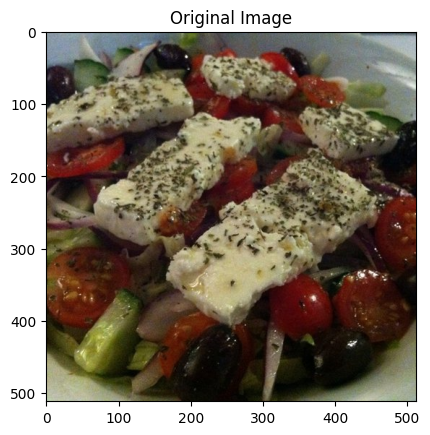

In [6]:
target_class = random.choice(train_data.class_names)
target_dir = "101_food_classes_10_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title("Original Image")

## Model 0 - 10% data of 101 classes of images

1. Create Model checkpoint
2. Create data augmentation layer
3. Build headless (no top layer) functional efficientnetb0 backboned moded.
4. Compile the mode
5. Feature extractor for 5 full passes (5 epochs on 15% of validation data)

Saving TensorBoard log files to: transfer_learning/1_per_data_aug/20240304-041920
Epoch 1/5
237/237 [==============================] - 51s 180ms/step - loss: 3.5195 - accuracy: 0.2426 - val_loss: 2.6952 - val_accuracy: 0.3821
Epoch 2/5
237/237 [==============================] - 35s 148ms/step - loss: 2.4177 - accuracy: 0.4469 - val_loss: 2.2087 - val_accuracy: 0.4595
Epoch 3/5
237/237 [==============================] - 33s 139ms/step - loss: 2.0356 - accuracy: 0.5184 - val_loss: 2.0554 - val_accuracy: 0.4746
Epoch 4/5
237/237 [==============================] - 31s 132ms/step - loss: 1.8373 - accuracy: 0.5563 - val_loss: 1.9147 - val_accuracy: 0.5073
Epoch 5/5
790/790 [==============================] - 21s 26ms/step - loss: 1.6150 - accuracy: 0.5765


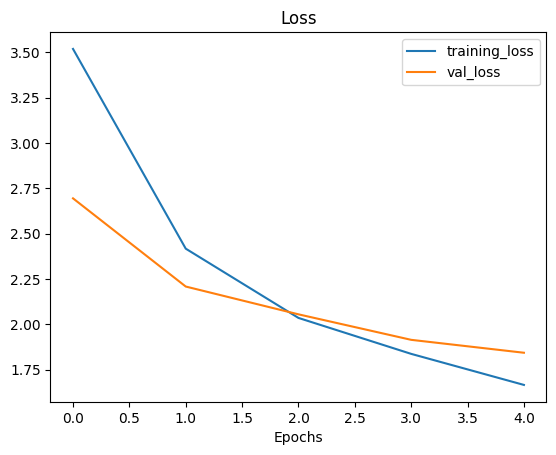

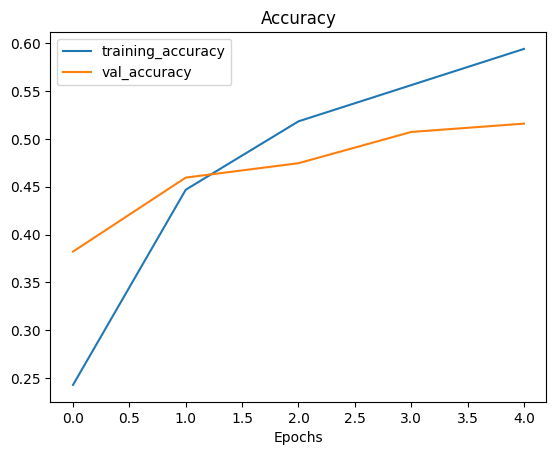

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup checkpointing
checkpoint_path = "101_food_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation")

number_of_classes = len(train_data.class_names)

# Create feature extractor model (Not-fine tunned) using efficient net as a base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

input_layer = layers.Input(shape=INPUT_SHAPE, name="input_layer")
x = data_augmentation(input_layer)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
output_layer = layers.Dense(number_of_classes, activation="softmax", name="output_layer")(x)

model_0 = tf.keras.Model(input_layer, output_layer)

model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the mode
history_model_0 = model_0.fit(train_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="1_per_data_aug"),
                                         checkpoint_callback])

# Evaluate the model on full test data
model_0.evaluate(test_data)

# Plot the training curves
plot_loss_curves(history_model_0)

## Model 1 - Fine Tunning

input_2 False
rescaling_1 False
normalization_1 False
stem_conv False
stem_bn False
stem_activation False
block1a_project_conv False
block1a_project_bn False
block1a_project_activation False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_project_conv False
block2b_project_bn False
block2b_drop False
block2b_add False
block3a_expand_conv False
block3a_expand_bn False
block3a_expand_activation False
block3a_project_conv False
block3a_project_bn False
block3b_expand_conv False
block3b_expand_bn False
block3b_expand_activation False
block3b_project_conv False
block3b_project_bn False
block3b_drop False
block3b_add False
block4a_expand_conv False
block4a_expand_bn False
block4a_expand_activation False
block4a_dwconv2 False
block4a_bn False
block4a_activation False
block4a_se_squeeze False
block4a_se_reshape False
blo

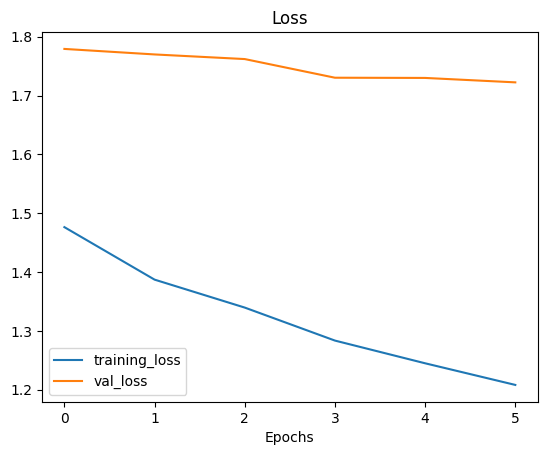

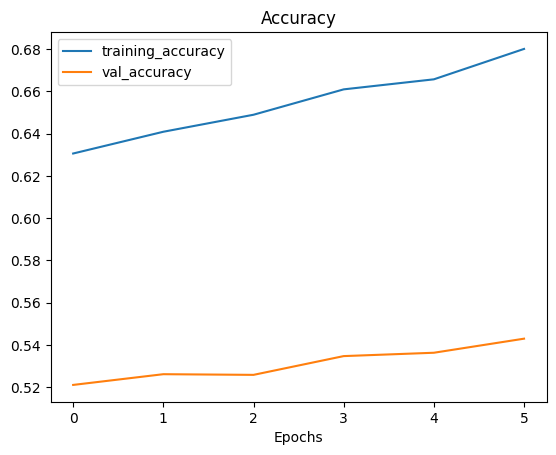

In [9]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False


# Recompile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

# Print which layers are trainable
for layer in base_model.layers:
  print(layer.name, layer.trainable)

history_model_2 = model_0.fit(train_data,
                              epochs=10,
                              steps_per_epoch=len(train_data),
                              validation_data=test_data,
                              initial_epoch=history_model_0.epoch[-1],
                              validation_steps=int(0.25 * len(test_data)),
                              callbacks=[ checkpoint_callback])

# Evaluate the model on full test data
model_0.evaluate(test_data)

# Plot the training curves
plot_loss_curves(history_model_2)

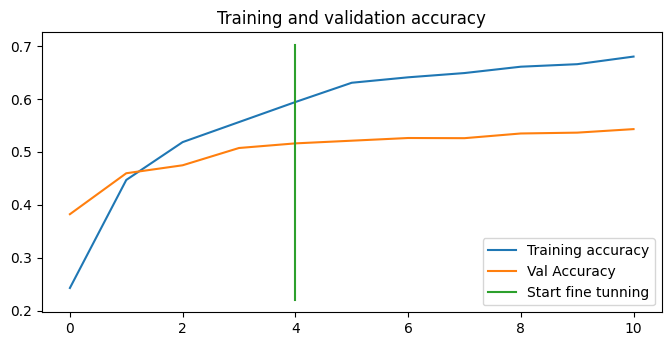

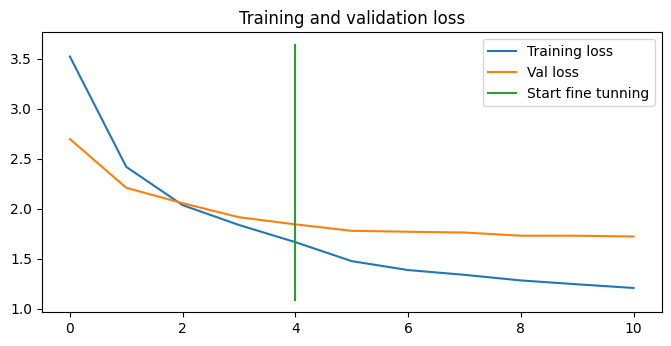

In [10]:
compare_historys(history_model_0, history_model_2)

## Saving and loading our model

**Model can be saved and later downloaded and reloaded to perform the inferences**

In [11]:
model_0.save("drive/MyDrive/101_food_classes_10_percent.model")

In [12]:
loaded_model = tf.keras.models.load_model("drive/MyDrive/101_food_classes_10_percent.model")
loaded_model.evaluate(test_data)

790/790 [==============================] - 23s 27ms/step - loss: 1.4810 - accuracy: 0.6036


[1.481025218963623, 0.603643536567688]

## Evaluating performance of the model

In [13]:
pred_probs = loaded_model.predict(test_data, verbose=1)
print(pred_probs.shape)

790/790 [==============================] - 19s 22ms/step
(25250, 101)


In [14]:
pred_probs[:10]

array([[3.81577248e-03, 4.57761489e-05, 1.22334704e-01, ...,
        3.54751728e-06, 1.44605781e-03, 5.71847304e-05],
       [7.16550291e-01, 2.94300236e-07, 3.26590724e-02, ...,
        7.32212618e-04, 6.48124751e-06, 2.65355920e-04],
       [3.46889824e-01, 2.37051063e-04, 8.87326710e-03, ...,
        1.36904791e-03, 1.08828489e-03, 2.63954070e-03],
       ...,
       [1.85799822e-01, 1.57767931e-06, 3.40728015e-02, ...,
        6.89154665e-04, 6.50500297e-04, 1.15744455e-03],
       [1.38118207e-01, 5.71428500e-05, 6.21656440e-02, ...,
        2.91849091e-03, 2.63892434e-04, 9.59981815e-04],
       [5.04481375e-01, 4.00532883e-07, 3.47541296e-03, ...,
        1.69440557e-03, 1.75940004e-05, 3.81501508e-04]], dtype=float32)

In [15]:
pred_probs[0].argmax()

85

In [16]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([85,  0,  0,  0,  8, 78, 29, 46,  9,  0])

In [17]:
# Compare predicted labels to original labels
true_classes = [ test_labels.numpy().argmax() for _, test_labels in test_data.unbatch() ]
true_classes[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [18]:
## Accuracy score
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=true_classes, y_pred=pred_classes)
print(f"accuracy = {sklearn_accuracy}")

accuracy = 0.6036435643564356


### Confusion Matrix

In [21]:
from helper_functions import make_confusion_matrix

class_names = test_data.class_names
make_confusion_matrix(y_true=true_classes,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

# Modify helper functions after this to make labels verticle
# Add below code on line 96, 97
# plt.xticks(rotation=70, fontsize=text_size)
# plt.yticks(fontsize=text_size)

### Classification reports

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_true=true_classes, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.39      0.17      0.23       250
           1       0.68      0.61      0.64       250
           2       0.70      0.45      0.55       250
           3       0.72      0.58      0.64       250
           4       0.50      0.41      0.45       250
           5       0.63      0.31      0.41       250
           6       0.70      0.80      0.75       250
           7       0.84      0.71      0.77       250
           8       0.38      0.49      0.43       250
           9       0.35      0.76      0.47       250
          10       0.57      0.43      0.49       250
          11       0.68      0.57      0.62       250
          12       0.77      0.58      0.67       250
          13       0.63      0.54      0.58       250
          14       0.44      0.65      0.53       250
          15       0.34      0.37      0.35       250
          16       0.58      0.58      0.58       250
          17       0.37    

In [35]:
classification_report_dict = classification_report(y_true=true_classes,
                                                   y_pred=pred_classes,
                                                   output_dict=True)
classification_report_dict

{'0': {'precision': 0.3888888888888889,
  'recall': 0.168,
  'f1-score': 0.23463687150837992,
  'support': 250},
 '1': {'precision': 0.6785714285714286,
  'recall': 0.608,
  'f1-score': 0.6413502109704642,
  'support': 250},
 '2': {'precision': 0.7018633540372671,
  'recall': 0.452,
  'f1-score': 0.5498783454987834,
  'support': 250},
 '3': {'precision': 0.72, 'recall': 0.576, 'f1-score': 0.64, 'support': 250},
 '4': {'precision': 0.5024390243902439,
  'recall': 0.412,
  'f1-score': 0.45274725274725275,
  'support': 250},
 '5': {'precision': 0.6260162601626016,
  'recall': 0.308,
  'f1-score': 0.41286863270777474,
  'support': 250},
 '6': {'precision': 0.7007042253521126,
  'recall': 0.796,
  'f1-score': 0.745318352059925,
  'support': 250},
 '7': {'precision': 0.8356807511737089,
  'recall': 0.712,
  'f1-score': 0.7688984881209504,
  'support': 250},
 '8': {'precision': 0.375,
  'recall': 0.492,
  'f1-score': 0.4256055363321799,
  'support': 250},
 '9': {'precision': 0.345521023765996

In [37]:
class_f1_scores = {}
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']

class_f1_scores

{'apple_pie': 0.23463687150837992,
 'baby_back_ribs': 0.6413502109704642,
 'baklava': 0.5498783454987834,
 'beef_carpaccio': 0.64,
 'beef_tartare': 0.45274725274725275,
 'beet_salad': 0.41286863270777474,
 'beignets': 0.745318352059925,
 'bibimbap': 0.7688984881209504,
 'bread_pudding': 0.4256055363321799,
 'breakfast_burrito': 0.4742785445420327,
 'bruschetta': 0.48747152619589973,
 'caesar_salad': 0.6173913043478261,
 'cannoli': 0.6651480637813212,
 'caprese_salad': 0.5849462365591398,
 'carrot_cake': 0.526829268292683,
 'ceviche': 0.35294117647058826,
 'cheese_plate': 0.5816733067729084,
 'cheesecake': 0.43170320404721757,
 'chicken_curry': 0.46913580246913583,
 'chicken_quesadilla': 0.5860655737704917,
 'chicken_wings': 0.7045454545454545,
 'chocolate_cake': 0.560344827586207,
 'chocolate_mousse': 0.40977443609022557,
 'churros': 0.7280898876404495,
 'clam_chowder': 0.7342799188640975,
 'club_sandwich': 0.6733466933867734,
 'crab_cakes': 0.40672782874617736,
 'creme_brulee': 0.7296

In [40]:
# Create dataframe of f1 scores
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-scores": list(class_f1_scores.values())}).sort_values("f1-scores", ascending=False)

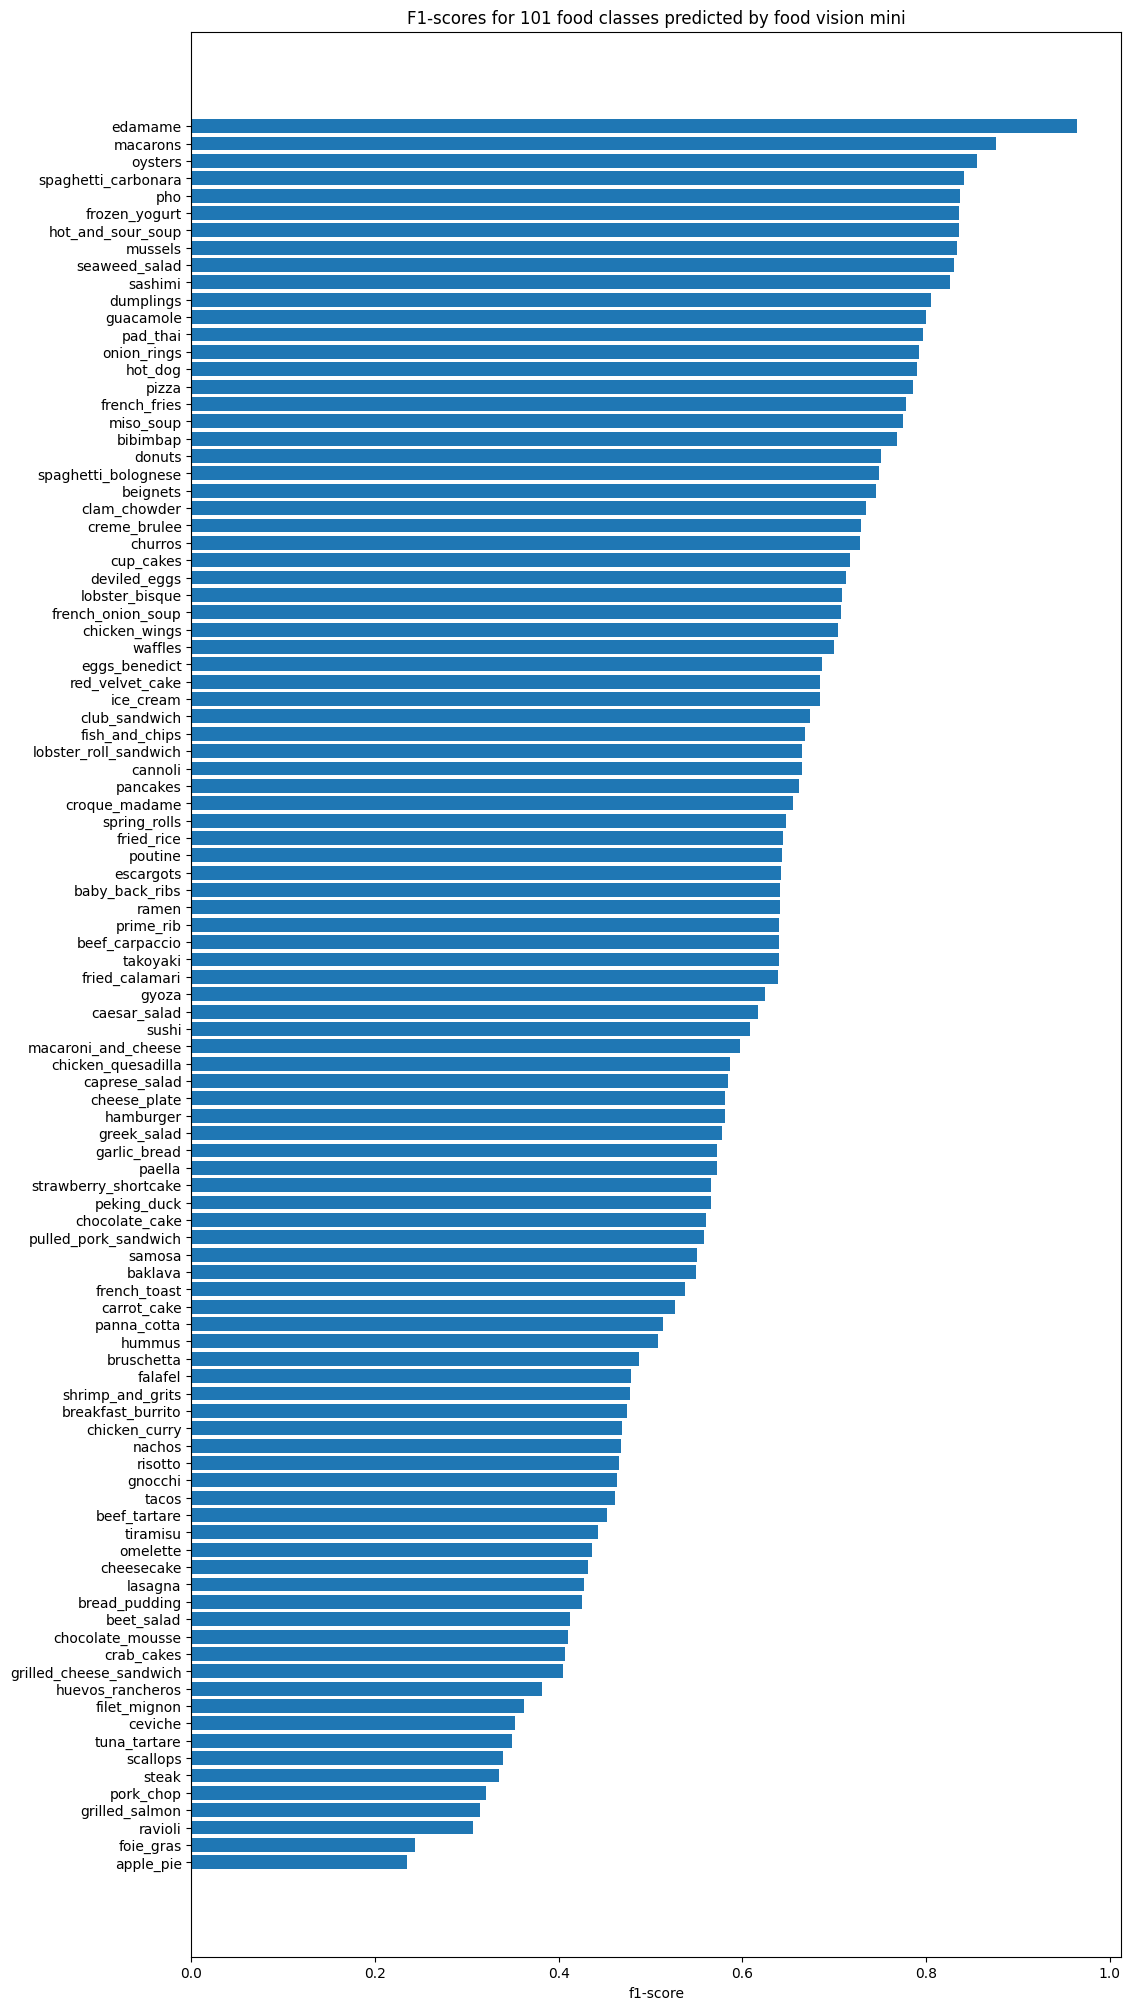

In [41]:
fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-scores"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("f1-score")
ax.set_title("F1-scores for 101 food classes predicted by food vision mini")
ax.invert_yaxis()